Dies ist das zentrale System <br>
Aufgabe des zentralen Systems sind: -Einfaches einlesen der Objekte <br>
 &emsp; -statistische Auswertung der Verkäufe <br>

Todo: <br>
Wie ändert man Bilder? Bilder werden bei änderung von id/name nicht angepasst <br>
Statistik muss aufgehübscht werden <br>
tables laufend updaten (mit tabchange) Anzeige updaten bei änderungen-sollte vermutlich jetzt gehen <br>
Trash collector <br>
Errors finden (Big change --> id dopppelt bei inc oder change)(
could be that #00000 are not correctly tombstoned in the manual creation?) Does import has problems with tags? <br>
Maybe save images under jpg to safe storage <br>
Dantenbank <- für x personen <- money

In [1]:
import sys 
from PyQt6.QtWidgets import *
import os.path
import os
import pandas as pd
from PyQt6.QtCore import Qt
import qrcode
import  time
from functools import partial
from PyQt6 import QtTest
import pickle
#import sip
import cryptpandas as crp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qtagg import NavigationToolbar2QT as NavigationToolbar
from matplotlib.backends.backend_qtagg import FigureCanvas
from PyQt6.QtGui import QPixmap
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df=[] #Sales objects (0) hierachies (1)
sales=pd.DataFrame()

Reading and writing files <br>
Objects contains information about the objects sold. Hierachies contain tree like structure of classes objects belong to for easy finding. <br>
For tax reasons sales need to have a safety mechanism against changes. The easiest way would be to limit the write access. However, since the files need to be moved manually between mobile and central devices, they are encripted and hashed instead. Transforming it into .exe the key is written into the programming making it hard to extract it.

In [27]:
def read_files(): #Reads sells objects (0) and classes (1)
    global df
    if len(df)!=0:
        df=[]
    for i in ["objects.json", "hierachies.json"]:
        if os.path.isfile(i):
            df.append(pd.read_json(i))
        else:
            df.append(pd.DataFrame())
    if (len(df[0])>0) and (len(df[0].columns)!=8):
        print("What")
        return True#error_handler("CorruptedFile") #maybe add for corrupted hierachies
    return False

In [4]:
def safe_files():
    global df
    df[0].to_json("objects.json")
    df[1].to_json("hierachies.json")
    return read_files()

In [5]:
def getpassw():
    #from cryptography.fernet import Fernet
    global df
    if os.path.isfile("keypickle"):
        dbfile = open('keypickle', 'rb')    
        key=pickle.load(dbfile)
        dbfile.close()
    else:
        key = Fernet.generate_key()
        dbfile=open('keypickle', 'ab')
        pickle.dump(key, dbfile)
        dbfile.close()
    return key

In [6]:
def read_verkauf():
    global sales
    if not (os.path.isfile("sales.crypt") and os.path.isfile("hashpickle")):
        sales=pd.DataFrame()
        return
    pw=getpassw()
    sales=crp.read_encrypted(path='sales.crypt', password=str(pw))
    dbfile=open('hashpickle', 'rb')    
    hashv=pickle.load(dbfile)
    dbfile.close()
    x=sales["id"].apply(hash)
    y=sales["time"].apply(hash)
    z=sales["total"].apply(hash)
    hashv2=hash(x.sum()+y.sum()+z.sum())
    if hashv!=hashv:
        return "CorruptedFile"
        print("corrupted")
    return False

In [7]:
def error_handler(kind, path=""): #implemented for repeated use, however often dismissed bc one time cases
    match kind:
        case "!Name": return "Namen, die mit '!' beginnen, sind für gelöschte Elemente vorenthalen."
        case "CorruptedFile": return "Your objects-file is corrupted. The colums don't line up with the expectation."
        case "nopath": return "Unter den Pfad "+str(path)+" wurde keine Datei gefunden"
        case "Int_pb": return "Preis oder Bestand müssen eine Nummer sein."
        case "Subzero": return "Preis oder Bestand sollten Positiv sein."
        case "Hierachie": return "Deine Hierachie wurde noch nicht definiert."
        case "Int_id": return "Deine ID ist keine Nummer. Sollten keine weiteren Warnungen auftauchen wurde das Objekt weiterhin gespeichert."
        case "MRoot": return "'.' Ist der allererste Startpunkt und darf keinen Vorgänger haben."
        case "NotField": return "Notwendige Felder wurden nicht ausgefüllt."
        case "Empty": return "Diese Hierachiestruktur existiert bereits."
        case "MFloat": return "Es wurden bei den Größenvergleich keine Nummerfelder gewählt."
        case "MString": return "Bitte geben sie Spalten an, welche Texte enthalten"
        case "NoID": return "Jedes Objekt braucht eine ID oder Name."
        case "ID": return "Es gibt Duplikate bei der ID"
        case _: "Unknown Error"

Sells objects contain variables for identification: name, id, img <br>
 &emsp;  variables for finding: altname, tags, hierachie <br>
 &emsp;  variables for buisness statistics: price and bestand <br>
id is the key but names are also required as checksums for the qr-code and human overview. <br>
At first id was supposed to be a machine generated number to reduce manual labour however people already have implemented systems. <br>
Deleted objects get marked with an "!" in front of the name but remain in the system unless it gets manually replaced.

In [8]:
class product:
    
    def __init__(self, name=None, id=None, altname="", price=0, tag="", bestand=0, hierachie="", image="", dict={}): #altid zu einer id

        if dict:
            for key, value in dict.items():
                setattr(self, key, value)
        else:
            self.name=name
            self.id=id
        
            self.altname=altname
            self.price=float(price)
            self.bestand=int(bestand)
            self.tag=tag
            self.hierachie=hierachie
            self.image=image
            
        if not self.id:
            raise TypeError
        if not self.name:
            raise TypeError

In [9]:
def errorProduct(proto, n_id, n_name, showError): #makes simple check that products follow certain conditions
    val={"altname": [], "tag": [], "hierachie": [], "bestand": 0, "price": 0, "image": ""}
    out={}
    for column, n_text in proto.items():
        if type(n_text)==str: 
            n_text=eSpace(n_text) #be prepared for ugly overwrites
        if pd.isna(n_text):
            if (column=="id") or (column=="name"):
                return False
            n_text=val[column]
            out[column]=n_text
            continue
        match column:
            case "id":
                if does_exidst(n_text, n_name, n_id, n_name):
                    showError("Doppelte ID")
                    return False
                if n_text=="#00000" and (n_text!=n_id):
                    showError("#00000 ist nur für temporäre Speicherung geeignet")
                    return False
                if n_text=="":
                    showError(error_handler("NotField"))
                    return False
                if not can_float(n_text):
                    showError(error_handler("Int_id")) #if id is not a number, it won't be an error just a warning
                else:
                    n_text=float(n_text) #with float ploblem with float tured into string but also bad when float get turned into int
            case "name":
                if does_exidst(n_id, n_text, n_id, n_name):
                    print("da")
                    showError("Doppelte ID")
                    return False
                if (n_text[0]=="!") and (n_name[0]!="!"):
                    showError(error_handler("!Name"))
                    return False
                if n_text=="":
                    showError( error_handler("NotField"))
            case "price" | "bestand":
                n_text=is0(n_text)
                if not can_float(n_text):
                    print(n_text)
                    showError(error_handler("Int_pb"))
                    return False
                if float(n_text)<0:
                    showError(error_handler("Subzero"))
                    return False
                n_text=float(n_text)
            case "hierachie":
                n_text=to_hlist(n_text)
                if n_text==False:
                    showError("Etwas stimmt mit der Hierachie nicht")
                    return False
            case "tag":
                if type(n_text)==float:
                    print(n_text)
                n_text=splitIt(n_text)
            case "altname":
                n_text=splitIt(n_text)
                for i in range(len(n_text)):
                    if n_text[i]=="":
                        n_text.pop(i)  
                    if (n_text[i][0]=="!"):
                        showError(error_handler("!Name"))
                        return False
        out[column]=n_text
    return out          

In [10]:
def does_exidst(e_id, e_name, alt_id, alt_name): #was bei änderung von product
    global df
    if len(df[0])==0:
        return False
    if (e_id==alt_id) & (e_name==alt_name):
        n=1
    else:
        n=0
    ph=df[0][df[0].id==e_id]
    if len(ph)>n:
        if (e_id=="#00000") or (e_name[0]=="!") or (all(ph.name.str.startswith("!",  na=False))) or all(ph.id=="#00000"):
            if len(ph[ph.name==e_name])>n:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

In [11]:
def deleteEntry(to_del, showError):
    global df
    for i in to_del:
        id_places=df[0][(df[0].id==i[1]) & (df[0].name==i[0])]
        if len(id_places)>1:
            showError(str(i)+"Mehr als eine id")
            orbital_space_canon()
            continue
        if (str(i[0])[0]=="!"):
            showError(str(i)+" ist bereits tot")
            continue
        places_tobe=df[0][(df[0].id==i[1]) & (df[0].name=="!"+str(i[0]))]
        if len(places_tobe)!=0:
            showError(str(i)+" hat bereits einen toten Eintrag. ALter Eintrag wird gelöscht")
            df[0].drop(places_tobe.index)
                
        df[0].loc[id_places.index[0], "name"]="!"+str(df[0].loc[id_places.index[0], "name"])

Hierachical structures are build like a tree. <br>
As of right now, visualization of the created hierachie is missing. Because of this managing systems like deleting or checks are missing. <br>
Because of the way of implementation cycles are prevented

In [12]:
class tree:
    def __init__(self, name):
        self.name=name #check double name
        self.children=[]
        self.parents=[]
    
    def add_child(self, child):
        if child in self.children:
            return False
        self.children.append(child)
        
    def add_parent(self, parent):
        if parent in self.parents:
            return False
        self.parents.append(parent)

In [13]:
def to_hlist(msg): #turns strings of format '["name", index]' or index into ["name", index] and checks existing
    global df
    hierachie=splitIt(msg)
    if (len(hierachie)==0) or (hierachie==['']):
        return []
    if (len(hierachie)==1): #if entry just number add name
        if can_float(hierachie[0]):
            if (int(hierachie[0]) in df[1].index) and not all(df[1][df[1].index==int(hierachie[0])]["name"].isna()):
                hierachie=[df[1]["name"][int(hierachie[0])], int(hierachie[0])]
    if not can_float(hierachie[1]) or (len(hierachie)==0):
        return False
    hierachie[1]=int(hierachie[1])
    hierachie[0]=eSpace(hierachie[0])
    if (df[1]["name"][hierachie[1]]!=hierachie[0]) or len(hierachie)!=2:
        return False
    else:
        return hierachie

In [14]:
def insertchild(father, image):
    global df
    young=image.young.text()
    
    silbrings=df[1].loc[father[1], "children"] #check excists?
    for i in silbrings:
        if i[0]==young:
            return True
    
    baum=tree(str(young))
    baum.add_parent(father)
    #df[1]["children"][father[1]]
    if father!=[]:
        df[1].loc[father[1], "children"].append([str(young),len(df[1])])
    ph=pd.DataFrame().from_records(vars(o) for o in [baum]) #makes trees into dataframe
    df[1]=pd.concat([df[1],ph],ignore_index=True)
    print(str(baum.name)+" erstellt")
    safe_files()
    return read_files()

When you delete an entry in hierachie, you have the problem, that children and parents are connected via indexes. To prevent chaos you can either fill an index with nans(which will cause the tree to blow up over time) or you can go through all parent/cildren and reduce the index over the deleted item by one (which will require calculation power). Afterwards you delete/reconnect all conecotion to the index. <br>
Cleaning the tree of nans in the future will be a omblicated story because of the varying amount of free fields. It first needs to identify the free fields then make a list of how many free fields are below every entry of the tree and then connect them to the indexes of the parent and child... this would also be needed for the complete deletion of all the following children... <br>
Okay simple delete will only fill up the nans, complete deletes will clean the whole tree <br>
Annoying: Still largeley possible to have same name children to hierachie when deleting

In [15]:
def delete_hierachie(wer):
    print(df[1])#better safe than sorry
    
    parent=df[1].iloc[wer[1]]["parents"][0] #should only be one parent
    df[1].iloc[parent[1]].children.remove(wer)
    df[1].iloc[parent[1]].children+=df[1].iloc[wer[1]]["children"]
    for i in df[1].iloc[wer[1]]["children"]:
        df[1].iloc[i[1]].parents=[parent]
    df[1].iloc[wer[1]]=pd.NA #or *len(applylambda)
    df[0][df[0]["hierachie"].apply(lambda x: wer[1] in x)]=df[0][df[0]["hierachie"].apply(lambda x: wer[1] in x)].apply(lambda x: [])
    print (df[1])
    safe_files()
    read_files()
    return parent

def getchild(parent, previous=[]): ###would not work without mutexes if parallelized
    if df[1].iloc[parent[1]].children==[]:
        return previous
    previous+=(df[1].iloc[parent[1]].children)
    for i in df[1].iloc[parent[1]].children:
        return getchild(i, previous)

def delete_hierachieC(wer):
    print(df[1])#better safe than sorry
    print(df[0])
    
    parent=df[1].iloc[wer[1]]["parents"][0] #should only be one parent
    df[1].iloc[parent[1]].children.remove(wer)
    todel=getchild(wer)
    todel.append(wer)
    print(todel)
    for i in todel:
        df[1].iloc[i[1]]=pd.NA
    ################################### ugly and slow
    howMuch=[]#0*len(df[1])] 
    k=0
    for index, row in df[1].iterrows():
        howMuch.append(k)
        if any(row.isna()):#from_records makes trees into dataframe
            k+=1
    df[1]=df[1][df[1]["name"].notna()]
    newdf=pd.DataFrame()
    for index, row in df[1].iterrows():#python hates rewriting loops
        baum=tree(df[1]["name"][index])#row.name) #can be cut to two lines
        print(baum.name)
        for i in row.parents:
            baum.add_parent([i[0],i[1]-howMuch[i[1]]])
        for i in row.children:
            baum.add_child([i[0],i[1]-howMuch[i[1]]])
        ph=pd.DataFrame().from_records(vars(o) for o in [baum])
        newdf=pd.concat([newdf,ph],ignore_index=True)
    df[0]["hierachie"]=[[i[0], i[1]-howMuch[i[1]]] for i in df[0]["hierachie"]]
    df[1]=newdf
            
    print(df[1])#better safe than sorry
    print(df[0])
    safe_files()
    read_files() 
    return parent

Small functions for transformation/check into correct type

In [16]:
def can_float(i): #Can variable be turned into float?
    try: 
        float(i)
        return True
    except:
        return False

In [17]:
def is0(i): #empty fields are tunred to 0 for e.g. prices
    if i=="":
        i=0
    return i

In [18]:
def splitIt(i): #turns string into array for e.g. altname
    if type(i)==list:
        return i
    if i[0]=="[":
        i=i[1:-1]
    i=i.split(",")
    i=eSpace(i)
    if i==['']:
        return[]
    return i

In [19]:
def propose_id(x): #to make it easier for the user an id based on the previous entry is preset in the formular
    if x=="":
        return 0
    if type(x)==int or type(x)==float:
        return x+1
    x=str(x)
    if len(x)>0 and x[-1]!="9":
        return x[:-1]+chr(ord(x[-1])+1)
    if len(x)>1:
        return x[:-2]+chr(ord(x[-2])+1)+"0"
    return x[:-2]+"10"

In [20]:
def eSpace(x): #erease whitespace surrounding entries
    if type(x)==list:
        y=[]
        for i in x:
            y.append(eSpace(i))
        return y
    else:
        while x.startswith(" ") or x.startswith("'") or x.startswith('"'):
            x=x[1:]
        while x.endswith(" ") or x.endswith("'") or x.endswith('"'):
            x=x[:-1]
    return x

Way over-computing functions that stops the user from using ids on living objects double or having two dead entries with same id and name. 

In [21]:
def orbital_space_canon():
    global df
    df[0].drop_duplicates(subset=['id', 'name'], inplace=True)
    df[0].drop(df[0][df[0].name=="!"].index)

In [22]:
def local_doom_laser():
    global df
    df1=df[0][~(df[0]["name"].str.startswith('!', na=True))]
    df2=df[0][(df[0]["name"].str.startswith('!', na=True))]
    df1.drop_duplicates(subset=['id'], inplace=True)
    df[0]=pd.concat([df1,df2], ignore_index=True)

Create different types of table in gui.
Depending on demand they can contan checkboxes or buttons as well as limit the entries in it.

In [23]:
class Tabelle(): 
    def __init__(self, df, boxes=False, qr=False, wer="Alle"):
        self.tableWidget=QTableWidget()
        self.qr_button={}
        self.checkboxes={}
        self.b_addimg={}
        self._makeTable(df, boxes, qr, wer)

    def _makeTable(self, df, boxes, qr, wer):
        if len(df)==0:
            return
        #wer=wer.currentText()
        
        if wer=="Nur Lebend": #change based on living/nonliving
            dfx=df[~(df.name.str.startswith("!", na=False))] 
        elif wer=="Alle": 
            dfx=df
        else:
            dfx=df[df.name.str.startswith("!", na=False)] 
            
        if len(dfx)==0:
            return
        self.tableWidget.setRowCount(len(dfx)+1)
        
        if (boxes!=False) and (qr!=False):##empty dictionaryies need seperation though !=False
            self.tableWidget.setColumnCount(len(dfx.columns)+2)
        elif boxes!=False:
            self.tableWidget.setColumnCount(len(dfx.columns)+1)
        else:
            self.tableWidget.setColumnCount(len(dfx.columns)+1) #framework end
            
        self.b_addimg={}
        for i in range(len(dfx.columns)): #name of colums upfront
            self.tableWidget.setItem(0,i+1, QTableWidgetItem(str(dfx.columns[i])))
        k=1 if boxes!=False else 0
        
        for i in dfx.columns:
            l=1
            for j in dfx[i]:
                call=(dfx["name"].iloc[l-1],dfx["id"].iloc[l-1])
                
                if i=="image":
                    if ((j=="") or (j==None)) and (qr): #
                        self.b_addimg[call]=QPushButton("addImg")
                        self.tableWidget.setCellWidget(l,k, self.b_addimg[call]) #add image
                        l+=1
                        continue
                    elif (j=="") or (j==None):
                        l+=1
                        continue
                    #image=Image.open(j)   
                    itemimage=QPixmap(j)#image)
                    itemimage=itemimage.scaledToHeight(40)
                    imlabel=QLabel()
                    imlabel.setPixmap(QPixmap(itemimage))
                    imlabel.setAlignment(Qt.AlignmentFlag.AlignHCenter)
                    self.tableWidget.setCellWidget(l,k, imlabel) #add image
                    l+=1
                    continue
    
                if (i=="tag") or (i=="hierachie") or (i=="altname"): 
                    self.tableWidget.setItem(l,k, QTableWidgetItem(str(j)[1:-1]))
                    l+=1
                    continue
                                        
                self.tableWidget.setItem(l,k, QTableWidgetItem(str(j))) #everything stringy gets added here
                    
                #each item gets a checkbox and qr-button unless it is testdata, then only a checkbox that needs both keys
                if i=="id":
                    if qr!=False:
                        if (call[1]!="#00000") and (call[0][0]!="!"):
                            self.qr_button[call]=QPushButton("QR-Code")
                            self.tableWidget.setCellWidget(l,len(dfx.columns)+1, self.qr_button[call])
                    if boxes!=False:
                        self.checkboxes[call]=QCheckBox() 
                        self.tableWidget.setCellWidget(l,0, self.checkboxes[call])
                        
                l+=1
            k+=1
        self.tableWidget.resizeColumnsToContents()
        self.tableWidget.resizeRowsToContents()
        self.tableWidget.horizontalHeader().setStretchLastSection(False)


In [24]:
def expand_tableS(places, p_table, start): #input places into simple table without images or buttons
    for i in range(len(places.columns)):
        p_table.setItem(1,i,QTableWidgetItem(str(places.columns[i]))) ###############externe function?
    for i in range(len(places.columns)): #add items
        k=start
        for j in places[places.columns[i]]:
            p_table.setItem(k,i,QTableWidgetItem(str(j)))
            k+=1
    p_table.horizontalHeader().setStretchLastSection(False)
    return p_table

In [25]:
def del_widget(widget, layout=None): #no table but used often
    if layout:
        layout.removeWidget(widget)
    widget.deleteLater()
    widget=None

In [28]:
read_files()
read_verkauf()

False

Overview of the provided sels objects<br>
Possibility to delete/change objects on bulk. Allows generation of Qr-Codes used as identification in the mobile programm

In [27]:
class App_Overview(QMainWindow): #prev App_View
    
    def __init__(self):
        global df
        super().__init__(parent=None)
        ph=read_files()
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.setCentralWidget(centralWidget)
        if not ph:
            self.showError(ph)
        self.lerrors=QLabel("") #invisible unless errors appear
        self.layout.addWidget(self.lerrors)
        self._createSetting()
        self._createTable(False)
        #self.wer.currentIndexChanged.connect(self._createTable)


    def _createSetting(self):
        #self.bM=QPushButton("")
        buttons=QHBoxLayout()
        l1=QLabel("Deine Objekte")
        self.del_button=QPushButton("Delete")
        self.b_revive=QPushButton("Revive")
        self.wer=QComboBox()
        self.wer.addItem("Nur Lebend")
        self.wer.addItem("Alle")
        self.wer.addItem("Tote")
        #self.change_button=QPushButton("Change")
        self.layout.addWidget(l1)
        buttons.addWidget(self.wer)
        buttons.addWidget(self.del_button)
        buttons.addWidget(self.b_revive) #easier to do nothing to living/dead objects than hiding/showing revive/delete depending on wer
        #buttons.addWidget(self.change_button)
        buttons.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.layout.addLayout(buttons)

    def _createScroll(self):
        self.scroll=QScrollArea()
        self.scroll.setWidget(self.tableWidget)
        self.scroll.setWidgetResizable(True)
        self.scroll.setMaximumHeight(400)
        self.layout.addWidget(self.scroll)

    def _createTable(self, flag=True): #######################need figure out workaround for flag
        global df
        if flag:
            del_widget(self.scroll, self.layout)
            del_widget(self.tableWidget)
        self.ov_tabelle=Tabelle(df=df[0], boxes=True, qr=True, wer=self.wer.currentText())
        self.tableWidget=self.ov_tabelle.tableWidget
        self.qr_button=self.ov_tabelle.qr_button
        self.checkboxes=self.ov_tabelle.checkboxes
        self.b_addimg=self.ov_tabelle.b_addimg
        Control_Overview(self)#############################ugly but needs permanent update
        self._connectSignalsAndSlots()
        self._createScroll()
        
        
    def _connectSignalsAndSlots(self):
        self.tableWidget.itemChanged.connect(partial(changed_table, wer=self.wer,current=self.tableWidget, showError=self.showError))
        if len(df[0])!=0:
            for id, button in self.qr_button.items():
                button.clicked.connect(partial(buildQR, id))
    
    
    def showError(self, msg):
        self.lerrors.setText(msg)
        QtTest.QTest.qWait(5000)
        self.lerrors.setText("")

In [28]:
def changed_table(item, wer, current, showError): 
    global df
    wer=wer.currentText()
    if wer=="Nur Lebend":
        dfx=df[0][~(df[0].name.str.startswith("!", na=False))] 
    elif wer=="Alle": 
        dfx=df[0]
    else:
        dfx=df[0][df[0].name.str.startswith("!", na=False)] 
    
    n_text=current.currentItem().text()
    n_column=df[0].columns[item.column()-1]
    n_id=dfx["id"].iloc[item.row()-1]
    n_name=dfx["name"].iloc[item.row()-1]
    proto={n_column:n_text}
    n_text=errorProduct(proto=proto, n_id=n_id, n_name=n_name, showError=showError)
    
    if n_text==False:
        return True
        
    place=df[0][(df[0].name==n_name)&(df[0].id==n_id)].index[0]
    #df[0][n_column].iloc[item.column()-1]=n_text
    if (n_column=="hierachie") or (n_column=="tag") or (n_column=="tags") or (n_column=="altname"):
        df[0].loc[place, n_column].clear()
        df[0].loc[place, n_column].extend(n_text[n_column])
    else:
        df[0].loc[place, n_column]=n_text[n_column]
        
    return False

In [29]:
def buildQR(call):
    global df
    qr = qrcode.QRCode()
    ph={"id":call[1],
       "name":call[0]}
    qr.add_data(ph)
    qr.make(fit=True)
    img=qr.make_image(fill_color="black", back_color="transparent")
    img.save(str(call[1])+"-"+str(call[0])+".png")

In [30]:
class Control_Overview: #prev Control_II
    
    def __init__(self, view, master=None):
        self._view = view
        self._master=master
        self._connectSignalsAndSlots()

    def _connectSignalsAndSlots(self):
        global df
        for id, button in self._view.b_addimg.items():
                button.clicked.connect(partial(self._importImage, id))
        self._view.del_button.clicked.connect(self._delAll)
        self._view.b_revive.clicked.connect(self._reviveAll)
        self._view.wer.currentIndexChanged.connect(partial(self._view._createTable,True)) ########new wertable
        
    def _reviveAll(self):
        global df
        if self._view.wer.currentText()=="Nur Lebend":
            return
        to_del=[]
        
        for call, button in self._view.checkboxes.items():
            if button.isChecked()==True:
                to_del.append(call)
                
        for i in to_del:
            id_places=df[0][(df[0].id==i[1]) & (df[0].name==i[0])]
            if len(id_places)>1:
                self._view.showError(str(i)+"Mehr als eine id")
                orbital_space_canon()
                continue
            if not (str(i[0])[0]=="!"):
                self._view.showError(str(i)+" lebt bereits eine lebende id")
                continue
            places_tobe=df[0][(df[0].id==i[1]) & (df[0].name==str(i[0])[1:])]
            if len(places_tobe)!=0:
                self._view.showError(str(i)+" hat bereits einen lebenden Eintrag. Nichts passiert.")
                continue
            
            df[0].loc[id_places.index[0], "name"]=df[0].loc[id_places.index[0], "name"][1:]

        safe_files()
        self._view._createTable() #changes xux
        self._view.showError("Alle Daten restored")

    def _delAll(self):
        global df
        if self._view.wer.currentText()=="Tote":
            return
        to_del=[]
        
        for call, button in self._view.checkboxes.items():
            if button.isChecked()==True:
                to_del.append(call)
                
        deleteEntry(to_del, self._view.showError)
        safe_files()
        self._view._createTable() #changes xux
        self._view.showError("Alle Daten gelöscht")

        
    def _importImage(self, call):
        global df
        fname=QFileDialog.getOpenFileName(self._view, "Open file","c\\","Image files (*.jpg *.gif *.png)")
        imagePath=fname[0]
        if imagePath:
            try:
                os.mkdir("Bee_Sloth_Images")
            except:
                print("Path exists")
        image=Image.open(imagePath)
        width, height = image.size
        scale=300/width
        s_image=image.resize((int(scale*width),int(scale*height)))
        #m_sharp=m_sharp.convert('RGB')
        i_path=os.getcwd()+"\\Bee_Sloth_Images\\"+str(call[0])+"-"+str(call[1])+".png"
        s_image.save(i_path)
        df[0].loc[((df[0].id==call[1]) & (df[0].name==call[0])), "image"]=str(i_path)
        safe_files()
        #return False
                

In order to allow large scale changes Filtered changes allows to change all objects following selected coditions to change in selected ways. <br>
The selection includes: <br>
The changes include: <br>

In [31]:
class App_Filtered(QMainWindow): #super_Change Das Monster von Loch Loch

    def __init__(self):
        global df
        super().__init__(parent=None)
        #ph=read_files()
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.setCentralWidget(centralWidget)

        self.bM=QPushButton("")
        self.lerrors=QLabel("") #######addWridged?
        self._createSetting()
        self.layout.addWidget(self.lerrors)
        self._createTable(flag=False)

    def _addQuri(self, flag=False):
        self.wers.append(Wer_Class(self.popparent, len(self.wers), flag))
        self.al_l_wer.addLayout(self.wers[-1].l_wer)

    def popparent(self,n):
        self.wers.pop(n)
        
    def _createSetting(self):
        self.wers=[]
        self.al_l_wer=QVBoxLayout() #Necessary to keep in place when more queries are added later on
        self.layout.addLayout(self.al_l_wer)
        self._addQuri(True)
        
        self.mor_quri=QPushButton("Weitere Bedingung")
        self.layout.addWidget(self.mor_quri)
        self.mor_quri.clicked.connect(self._addQuri)
        self.b_apply=QPushButton("Bedingungen anwenden")
        self.layout.addWidget(self.b_apply)
        #self.b_reset=QPushButton("Reset")
        #self.layout.addWidget(self.b_reset)
        #self.b_apply.clicked.connect(self._)
        
        self.was=Was_Class(self.layout)
        self.b_change=QPushButton("Change")
        self.b_changeSel=QPushButton("Change only selected")
        self.layout.addWidget(self.b_change)
        self.layout.addWidget(self.b_changeSel)

    def _createScroll(self): ##############outsource
        self.scroll=QScrollArea()
        self.scroll.setWidget(self.tableWidget)
        self.scroll.setWidgetResizable(True)
        self.scroll.setMaximumHeight(400)
        self.layout.addWidget(self.scroll)
        
        self.sel_all=QPushButton("select_all")
        self.layout.addWidget(self.sel_all)
        self.sel_all.clicked.connect(self._checkAll)
        

    def _createTable(self, flag=True): #remove condition from table
        global df
        if flag:
            del_widget(self.tableWidget)
            del_widget(self.sel_all, self.layout)
            del_widget(self.scroll, self.layout)
            subset=werChange(self.wers, self.showError)
        else:
            subset=df[0]
            
        self.ph_tabelle=Tabelle(df=subset, boxes=True) #wer=based on wer
        self.tableWidget=self.ph_tabelle.tableWidget
        self.checkboxes=self.ph_tabelle.checkboxes
        
        #self._connectSignalsAndSlots()
        self._createScroll()

    def _checkAll(self):
        for i,j in self.checkboxes.items():
            j.setChecked(True)

    def showError(self, msg):
        self.lerrors.setText(msg)
        QtTest.QTest.qWait(5000)
        self.lerrors.setText("")

In [32]:
class Wer_Class(): #creates the gui for the check of who to change
    def __init__(self, popparent, n, erster=False,):
        self.furCol=QComboBox() #Conditions in the way of: entries of furCol which fits wergenau value as verleichswert
        self.wergenau=QComboBox() #Bedingung
        self.vergleichswert=QLineEdit() #value for Condition
        self.popparent=popparent #external function for removing class from array
        self.place=n #place in array

        self.rem_q=QPushButton("Remove Bedingung") #remove query/condition
        self._createWer(erster)

    def _createWer(self, erster): ##########wo erstellen insertWidget
        global df
        self.l_wer=QHBoxLayout()
        
        for i in df[0].columns:
            if i!="image":
                self.furCol.addItem(i) #removeItem/clear()
        self._adaptWergenau(self.furCol.currentText())

        self.l_wer.addWidget(self.furCol)
        self.l_wer.addWidget(self.wergenau)
        self.l_wer.addWidget(self.vergleichswert)
        
        if not erster:
            self.l_wer.addWidget(self.rem_q)
            
        self.furCol.currentTextChanged.connect(self._adaptWergenau)
        self.rem_q.clicked.connect(self._destroy)

    def _adaptWergenau(self, text):
        self.wergenau.clear()
        self.wergenau.addItem("ist genau")
        match text:
            case "id":
                self.wergenau.addItem("starten mit")
                self.wergenau.addItem("enden mit")
                self.wergenau.addItem("enthalten Wort")
                if df[0]["id"].dtype!='O':
                    self.wergenau.addItem("größer als")
                    self.wergenau.addItem("größer gleich als")
                    self.wergenau.addItem("kleiner als")
                    self.wergenau.addItem("kleiner gleich als") 
            case "altname"|"tag"|"name":
                self.wergenau.addItem("starten mit")
                self.wergenau.addItem("enden mit")
                self.wergenau.addItem("enthalten Wort")
            case "price"|"bestand":
                self.wergenau.addItem("größer als")
                self.wergenau.addItem("größer gleich als")
                self.wergenau.addItem("kleiner als")
                self.wergenau.addItem("kleiner gleich als")    
            case "hierachie":
                self.wergenau.addItem("ist und oder Subkategorie von")
                self.wergenau.addItem("ist Subkategorie von")
                

    def _destroy(self):
        del_widget(self.furCol,self.l_wer)
        del_widget(self.wergenau,self.l_wer)
        del_widget(self.vergleichswert,self.l_wer)
        del_widget(self.rem_q,self.l_wer)
        self.l_wer=None
        self.popparent(self.place)
            
#self.al_l_wer.addLayout(l_wer)
#self.ke+=1
    

In [33]:
class Was_Class(): #creates the gui of what should be how changed
    def __init__(self, layout):
        self.wasCol=QComboBox() #colum to change
        self.wie=QComboBox()
        self.umwas=QLineEdit()
        self._fillout(layout)

    def _fillout(self, layout):
        global df
        for i in df[0].columns:
            if i!="image":
                self.wasCol.addItem(i)

        self._adaptWie(self.wasCol.currentText())

        layout.addWidget(self.wasCol)
        layout.addWidget(self.wie)
        layout.addWidget(self.umwas)

        self.wasCol.currentTextChanged.connect(partial(self._adaptWie))

    def _adaptWie(self, text):
        print("ddddddddd")
        self.wie.clear()
        self.wie.addItem("lösche die Objekte komplett")
        match text:
            case "id":
                self.wie.addItem("ändere jeden Buchstaben A->B")
                self.wie.addItem("setze vor Wort")
                self.wie.addItem("setze hinter Wort")
            case "hierachie":
                self.wie.addItem("ersetze alles mit")
                self.wie.addItem("leere Spalte")
            case "price"|"bestand":
                self.wie.addItem("ersetze alles mit")
                self.wie.addItem("leere Spalte")
                self.wie.addItem("ändere Betrag um")
            case "altname"|"tag":
                self.wie.addItem("ersetze alles mit")
                self.wie.addItem("leere Spalte")
                self.wie.addItem("füge das hinzu")
                self.wie.addItem("ändere jeden Buchstaben A->B")
                self.wie.addItem("setze vor Wort")
                self.wie.addItem("setze hinter Wort")
            case "name":
                self.wie.addItem("ändere jeden Buchstaben A->B")
                self.wie.addItem("setze vor Wort")
                self.wie.addItem("setze hinter Wort")
                

In [34]:
def werChange(wers, showError): #transforms the who to change into computer understanding
    global df
    expr=True
    for i in range(len(wers)):
        todo=wers[i].wergenau.currentText()
        furCol=wers[i].furCol.currentText()
        vw=wers[i].vergleichswert.text() #was wenn leer? gibt es Probleme?

        if furCol=="hierachie": #change type to column type
            vw=to_hlist(vw)
            if vw==False:
                showError("Der Vergleichswert stimmt nicht mit den Typen von "+str(furCol)+" überein.")
                return
        elif df[0][furCol].dtype!='O':
            if not can_float(vw):
                showError("Der Vergleichswert stimmt nicht mit den Typen von "+str(furCol)+" überein.")
                return
            vw=float(vw)
        
        match todo: #build into understandable conditions
            case "ist genau": 
                if (furCol=="altname")|(furCol=="tag")|(furCol=="hierachie"):
                    if (furCol=="altname")|(furCol=="tag"):
                        vw=splitIt(vw)
                    expr=expr & df[0][furCol].apply(lambda x: x==vw)
                else:
                    expr=expr & (df[0][furCol]==vw)
            case "starten mit": 
                expr=expr & df[0][furCol].astype(str).str.startswith(str(vw), na=False)
            case "enden mit":
                expr=expr & df[0][furCol].astype(str).str.endswith(str(vw), na=False)
            case "größer als": 
                expr=expr & (df[0][furCol]>vw)
            case "größer gleich als":
                expr=expr & (df[0][furCol]>=vw)
            case "kleiner als":
                expr=expr & (df[0][furCol]<vw)
            case "kleiner gleich als":
                expr=expr & (df[0][furCol]<=vw)
            case "enthalten Wort":
                if (furCol=="altname") | (furCol=="tag"):
                     expr=expr & df[0][furCol].apply(lambda x: str(vw) in x)
                else:
                     expr=expr & df[0][furCol].astype(str).str.contains(str(vw), regex=False)
            case "ist und oder Subkategorie von":
                subexpr=df[0][furCol].apply(lambda x: x==vw)
                for k in getchild(vw):
                    subexpr=subexpr | (df[0][furCol].apply(lambda x: x==k))
                expr=expr & subexpr
            case "ist Subkategorie von":
                subexpr=False
                for k in getchild(vw):
                    subexpr=subexpr | (df[0][furCol].apply(lambda x: x==k))
                expr=expr & subexpr
                
    to_change=df[0][expr]
    if to_change.equals(df[0]):
        self._view.showError("Pass auf, die Auswahl ist die gesammte Auswahl")

    return to_change#, expr
                

In [35]:
class Control_Filtered: #Control_IV
    def __init__(self, view):#largeley just changeWer
        self._view = view
        self._connectSignalsAndSlots()

    def _connectSignalsAndSlots(self):
        global df
        self._view.bM.clicked.connect(lambda:(self._buildExpression("")))######################Dont ask why
        self._view.b_apply.clicked.connect(partial(self._view._createTable, True))
        #self._view.b_reset.clicked.connect(partial(self._view._createTable, False))
                                           
        self._view.b_changeSel.clicked.connect(partial(self._changeWer, "Selec")) 
        self._view.b_change.clicked.connect(partial(self._changeWer, "All")) 

    def _changeWer(self, selection): #transforming and apllying what to change
        global df
        if selection=="All":
            to_change=werChange(self._view.wers, self._view.showError)
        else:
            to_change=pd.DataFrame()
            for id, button in self._view.checkboxes.items():
                if button.isChecked()==True:
                    to_change=pd.concat([to_change, df[0].loc[(df[0].id==id[1]) & (df[0].name==id[0])]])#.index.to_list()]) #grulesome memory usage
                                 
        furCol=self._view.was.wasCol.currentText()
        wie=self._view.was.wie.currentText()
        vw=self._view.was.umwas.text()
        val={"bestand": 0, "price": 0} #largely copied from import
    
        if wie=="lösche die Objekte komplett": ########cases without umwas
            tochange=list(tochange.itertuples(index=False, name=None))
            deleteEntry(to_change, self._view.showError) #name ist 0, 1 id und rest wird nicht aufgerufen
            return
        elif wie == "leere Spalte":
            if furCol in val.keys():
                df[0].loc[to_change.index, furCol]=val[furCol]
            elif furCol in ["altname", "tag", "hierachie"]:
                df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: [])
            
    
        if furCol=="hierachie": ########change type to column type
            vwv=to_hlist(vvw)
            if vw==False:
                showError("Der Vergleichswert stimmt nicht mit den Typen von "+str(furCol)+" überein.")
                return
        elif df[0][furCol].dtype!='O':
            if not can_float(vw):
                showError("Der Vergleichswert stimmt nicht mit den Typen von "+str(furCol)+" überein.")
                return
            vw=float(vw)
    
        match wie: ####### outher cases
            case "ersetze alles mit":
                if (furCol=="altname")|(furCol=="tag")|(furCol=="hierachie"):
                    if (furCol=="altname")|(furCol=="tag"):
                        vw=splitIt(vw)
                    df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: vw)
                else:
                    df[0].loc[to_change.index, furCol]=vw
                                    
            case "ändere jeden Buchstaben A->B":
                ph=self._view.umwas.text().split("->")
                if len(ph)!=2:
                    self._view.showError(error_handler("MSplit"))
                    return
                if furCol=="id" or furCol=="name":
                    df[0].loc[to_change.index, furCol].str.replace(ph[0], ph[1])
                else:
                    df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: [s.replace(ph[0], ph[1]) for s in x])
                    
            case "setze vor Wort":
                if furCol=="id" or furCol=="name":
                    df[0].loc[to_change.index, furCol]=vw+df[0].loc[to_change.index, furCol]
                else: #"altname"|"tag"
                    df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: [(str(vw)+str(s)) for s in x])
                
            case "setze hinter Wort":
                if furCol=="id" or furCol=="name":
                    df[0].loc[to_change.index, furCol]+=vw
                else:
                    df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: [(str(s)+str(vw)) for s in x])
        
            case "ändere Betrag um":
                df[0].loc[to_change.index, furCol]+=vw
            case "füge das hinzu":
                df[0].loc[to_change.index, furCol]=df[0].loc[to_change.index, furCol].apply(lambda x: [x, str(vw)])
    
        
        for index, row in df[0].iloc[to_change.index].iterrows():
            proto=row.to_dict()
            print(proto)
            proto=errorProduct(proto=proto, n_id=proto["id"], n_name=proto["name"], showError=self._view.showError)
            if (proto==False):
                self._view.showError(str(row.id))
                read_files()
                return
            df[0].loc[index]=proto #is this illegal?
    
        if furCol=="id" or furCol=="name":
            orbital_space_canon()
            local_doom_laser()
            
        safe_files()
        self._view._createTable()

Simple statistical overview of sales. It shows important checkpoints for the year and allows a deeper look at specific time frames. It lists all the sales out. Furthermore it shows graphical compilation about the earnings each day, when each sell with with value was conducted, which part each item contributed and how much each tag/class contributed.

In [36]:
class App_Stat(QMainWindow):
    
    def __init__(self):
        global sales
        sales["price"]=sales["price"]*sales["amount"] #cando bc no safe
        super().__init__(parent=None)
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.setCentralWidget(centralWidget)

        if not sales.empty:
            self._createYearOv()
            self._createChooseOv()
            self._createVerk()
            
            self.upplayout=QHBoxLayout()
            self.lowlayout=QHBoxLayout()
            self.layout.addLayout(self.upplayout)
            self.layout.addLayout(self.lowlayout)
            
            self.upplayout.addLayout(self._addImage(plot_umsatz))
            self.upplayout.addLayout(self._addImage(plot_when))
            self.lowlayout.addLayout(self._addImage(plot_anteilII, "id"))
            self.lowlayout.addLayout(self._addImage(plot_anteilII, "tag"))

    def _createScroll(self):
        scroll=QScrollArea()
        scroll.setWidget(self.tableWidget)
        scroll.setWidgetResizable(True)
        scroll.setMaximumHeight(200)
        self.layout.addWidget(scroll)

    def _createVerk(self):
        global sales
        read_verkauf()
        l1=QLabel("Deine Verkäufe")
        self.layout.addWidget(l1)
        self.tableWidget=QTableWidget()
        
        ph_table=Tabelle(sales)
        self.tableWidget=ph_table.tableWidget
        
        self._createScroll()
        
    def _createYearOv(self):
        ylayout=QHBoxLayout()
        for i in salesbilanz().items():
            ylayout.addWidget(QLabel(str(i)))
        self.layout.addLayout(ylayout)

    def _createChooseOv(self):
        ylayout=QHBoxLayout()
        self.wer=QComboBox()
        self.wer.addItem("Woche")
        self.wer.addItem("Event")
        self.wer.addItem("Monat")
        ylayout.addWidget(self.wer)
        self._setlayout()
        ylayout.addLayout(self.yearlayout)
        self.layout.addLayout(ylayout)
        self.wer.currentTextChanged.connect(self._setlayout)

    def _setlayout(self):
        ylayout=QHBoxLayout()
        for i in salesbilanz(self.wer.currentText()).items():
            ylayout.addWidget(QLabel(str(i)))
        self.yearlayout=ylayout

    def _addImage(self, kind, klasse=None):
        if klasse:
            sc=kind(self, klasse)
        else:
            sc=kind(self)
        if not sc:
            return
        toolbar=NavigationToolbar(sc, self)
        layout=QVBoxLayout()
        layout.addWidget(toolbar)
        layout.addWidget(sc)
        return layout


In [37]:
def salesbilanz(duration="year"): #gives important stats over a selected time frame
    global sales
    weekd=pd.DataFrame()
    if sales.empty:
        return False
    overall={}
    
    match duration:
        case "Event":
            if not all(sales["event"].str.len()>0):
                return overall
            lastdate=sales.event
        case "date":
            lastdate=sales["time"].apply(lambda x: x.date())
        case "year":
            lastdate=sales["time"].apply(lambda x: x.year)
        case "month":
            lastdate=sales["time"].apply(lambda x: x.year)
            weekd=sales["time"].apply(lambda x: x.strftime("%m"))
        case _:
            lastdate=sales["time"].apply(lambda x: x.year)
            weekd=sales["time"].apply(lambda x: x.strftime("%V"))
            
    kauf=sales[lastdate==lastdate[-1:].iloc[0]] #all items sold that timeframe
    if not weekd.empty:
        kauf=kauf[weekd==weekd[-1:].iloc[0]] #all items sold that timeframe
    verkauf=kauf.groupby(["time"], as_index=False).first() #first item of a sale over the timeframe
    tage=verkauf.groupby(verkauf["time"].apply(lambda x: x.date()))["total"].sum().values #total umsatz over timeframe

    overall["av_Umsatz_pro_Verkauf"]=verkauf["total"].sum()/len(verkauf["total"])
    overall["Total"]=verkauf["total"].sum()
    overall["Am_haeufigsten_verkauft"]=kauf.groupby(["id","name"])["amount"].sum().idxmax()
    overall["Meister_Umsatz"]=kauf.groupby(["id"])["price"].sum().idxmax()
    overall["best_Day"]=kauf.groupby(kauf["time"].apply(lambda x: x.date()))["price"].sum().idxmax()
    if all(kauf.event.str.len()>0):
        print(kauf.event.str.len()>0)
        overall["best_Event"]=kauf.groupby(["event"])["price"].sum().idxmax()
    overall["day_av"]=tage.sum()/len(pd.unique(verkauf["time"].apply(lambda x: x.date())))
    return overall

In [38]:
class plot_umsatz(FigureCanvas): #plot the total sales of each day
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        global sales
        verkauf=(sales.groupby(["time"], as_index=False).first())
        s1=verkauf.groupby(verkauf["time"].apply(lambda x: x.date()))["total"].sum()
        fig=plt.figure(figsize=(12,4), dpi=100)
        ax=fig.add_subplot(1,1,1)
        ax.plot(s1.values,s1.index, linewidth=2.0)
        ax.set_xlabel("Gesammtumsatz des Tages in €")
        ax.set_ylabel('Tag')
        super().__init__(fig)
global sales #besser doppeltes gropuby not possible da groupbyobject


In [39]:
def plot_when(duration="week"): #shows scatterplot of when things were sold
    global sales #mabye hover
    fig, ax = plt.subplots(1, 1)

                       
class plot_when(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        global sales
        fig=plt.figure(figsize=(12,4), dpi=100)
        ax=fig.add_subplot(1,1,1)
        verkauf=(sales.groupby(["time"], as_index=False).first())
        s1=verkauf.groupby(verkauf["time"].apply(lambda x: x.date()))["total"].sum().index
        s2=verkauf.groupby(verkauf["time"].apply(lambda x: x.strftime("%X")))["total"].sum() #getUhrzeit
        ax.scatter(x=s2.index, y=s1, c=s2.values)
        ax.set_xlabel("Uhrzeit")
        ax.set_ylabel("Tag")
        ax.set_title("Zeit der Umsätze")
        super().__init__(fig)


In [40]:
class plot_anteil(FigureCanvas): #plot how much each item took part of the total sales
    def __init__(self, parent=None, klasse="id", width=5, height=4, dpi=100):
        global sales
        fig=plt.figure(figsize=(12,4), dpi=100)
        ax=fig.add_subplot(1,1,1)
        lastdate=sales["time"].apply(lambda x: x.date())
        barplt=pd.DataFrame()
        for i in pd.unique(lastdate):
            kauf=sales[lastdate==i]
            gkauf=kauf.groupby([klasse])["price"].sum()
            gkauf.name=i
            barplt=pd.concat([barplt, gkauft], axis=1) ####just horrible but I can't batch process
            #I could but then I had to go through every item
        barplt.fillna(0)
        ax=barplt.plot(x=barplt.columns, kind='bar', stacked=True,title='Parts of every item')
        ax.get_figure()
        super().__init__(fig)
        #ax = df.plot.barh()


In [41]:
class plot_anteilII(FigureCanvas): #shows how much each tag took part of the total sales
    def __init__(self, parent=None, klasse="id", width=5, height=4, dpi=300):
        global sales
        fig=plt.figure(figsize=(12,4), dpi=100)
        ax=fig.add_subplot(1,1,1)
        lastdate=sales["time"].apply(lambda x: x.date())
        uniquedate=pd.unique(lastdate)
        items={}
        legende=[]
        try:
            uniqueklasse=pd.unique(sales[klasse])
        except:
            print(klasse)
            super().__init__(fig)
            return
        for i in uniqueklasse:
            items[i]=[]
            for j in uniquedate:
                now=sales.loc[(sales.id==i) & (lastdate==j)]
                items[i].append(now.price.sum())
            plt.bar(uniquedate, items[i])
            if klasse=="id":
                legende.append(sales.loc[(sales.id==i)]["name"].iloc[0])
            else:
                legende.append(i)
        plt.xlabel("Tag")
        plt.ylabel("Einnahme")
        plt.legend(legende)
        ax=plt.title("Einnahme pro item")
        ax.get_figure()
        super().__init__(fig)
        #ax = df.plot.barh()


Faster integration through import of Data. Pased on adjustable parameters users might import a file. Afterwards the user can decide how each column translates into this program. Duplicates of ids will be removed. If an id is unknown it will get the placeholder id #00000. Placeholder ids can't generate QR-Codes nor can they be purchased. If Price and item does not exist, they will automatically get the value 0. They are soley integrated because changing an id is faster than typing all information of an item down.

In [42]:
class App_Import(QMainWindow): #App_Import
    def __init__(self):
        global df
        super().__init__(parent=None)
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.bM=QPushButton("")
        self.lerrors=QLabel("")
        self.alignIt=QPushButton("Abschicken")
        self.setCentralWidget(centralWidget)
        self._createSetting()
        #self._createVerarbeitung()
        
    def _createSetting(self):
        arrange=QFormLayout()
        self.s_file, self.s_num, self.s_sep, self.s_id=[QLineEdit(), QLineEdit(), QLineEdit(), QLineEdit()] #no I can't *4 try it
        l1=QLabel("Importier Teile oder ganze Objekte aus anderen Datein.")
        l2=QLabel("Reihen können genau so oder mit anderen Namen übernommen oder weggelassen werden.")
        "If str, then indicates comma separated list of Excel column letters and column ranges (e.g. “A:E” or “A,C,E:F”)."
        arrange.addRow(l1)
        arrange.addRow(l2)
        arrange.addRow("File Path:", self.s_file)
        arrange.addRow("Start at Line:", self.s_num)
        arrange.addRow("Seperator für CSV:", self.s_sep)
        arrange.addRow("Where Id or Names at", self.s_id)
        self.combobox1=QComboBox()
        self.combobox1.addItem("Exel")
        self.combobox1.addItem("CSV")
        self.combobox1.addItem("JSON")
        l3=QLabel("Duplikate nach der ersten Auftauchen in der 'Id or Names'-Spalte werden ignoriert. ")
        arrange.addWidget(self.combobox1)
        arrange.addRow(l3)
        self.c_komma=QCheckBox("',' sind Dezimaltrennzeichen", self)
        self.c_komma.setChecked(False)
        arrange.addWidget(self.c_komma)
        self.c_accept=QCheckBox("Fehlerhafte Reihen werden ignoriert und verhindern nicht das Einlesen des Restes", self)
        self.c_accept.setChecked(True)
        arrange.addWidget(self.c_accept)
        self.upl_button=QPushButton("Upload")
        arrange.addWidget(self.upl_button)
        self.layout.addLayout(arrange)
        self.layout.addWidget(self.lerrors)

    def createVerarbeitung(self, places):
        global df
        l1=QLabel("Align Attributes;") 
        l2=QLabel("Reihe 2 zeigt Spaltennamen aus Datei und wird nicht übernommen; Reihen von 'rauslassen' werden nicht übernommen.")
        self.layout.addWidget(l1)
        self.layout.addWidget(l2)
        self.layout.addWidget(self.alignIt)
        if places.empty:
            return

        p_table=QTableWidget()
        p_table.setRowCount(len(places)+2)
        p_table.setColumnCount(len(places.columns))
        self.col_line={}

        for i in range(len(places.columns)):
            self.col_line[i]=QComboBox()
            self.col_line[i].addItem("rauslassen")
            for j in df[0].columns:
                if j != "image":
                    self.col_line[i].addItem(j)
            p_table.setCellWidget(0,i, self.col_line[i])
            
        """    
        for i in range(len(places.columns)):
            p_table.setItem(0,i,QTableWidgetItem(str(places.columns[i])))
        for i in range(len(places.columns)):
            p_table.setItem(1,i,QTableWidgetItem(str(places.columns[i])))
        """
        
        p_table=expand_tableS(places, p_table, start=2)
        self.layout.addWidget(p_table)
    
    def showError(self, msg):
        self.lerrors.setText(msg)
        QtTest.QTest.qWait(5000)
        self.lerrors.setText("")

    def perError(self, msg):
        msg=self.lerrors.text()+"\n"+msg
        self.lerrors.setText(msg)



In [43]:
class Control_Import: #Control_III
    def __init__(self, view):
        self._view = view
        self._connectSignalsAndSlots()
        
    def _buildExpression(self, subExpression):
        return 

    def _connectSignalsAndSlots(self):
        self._view.bM.clicked.connect(lambda:(self._buildExpression("")))######################Dont ask why
        self._view.upl_button.clicked.connect(self._load)
        self._view.alignIt.clicked.connect(self._takeover)
        

    def _load(self):
        ph=self._view.combobox1.currentText()
        if ph=="Exel":
            self.ds=pd.read_excel(eSpace(self._view.s_file.text()),skiprows=is0(eSpace(self._view.s_num.text())))
        elif ph=="CSV":
            if eSpace(self._view.s_sep.text())=="":
                self.ds=pd.read_csv(eSpace(self._view.s_file.text()),
                                    skiprows=is0(eSpace(self._view.s_num.text())))
            else:   
                self.ds=pd.read_csv(eSpace(self._view.s_file.text()),sep=(eSpace(self._view.s_sep.text())), 
                                    skiprows=is0(eSpace(self._view.s_num.text())))
        elif ph=="JSON":
            self.ds=pd.read_json(eSpace(self._view.s_file.text()))
        if self._view.s_id.text():
            self.ds.drop_duplicates(subset=self._view.s_id.text(), inplace=True)
        self._view.createVerarbeitung(self.ds)

    def _takeover(self): #give columns new names and safe the new file
        global df
        collectdrop=[] #renaming
        for id, field in self._view.col_line.items():
            for id2, field2 in self._view.col_line.items(): #to much ckecked bad performance #check for duplicates
                if (field.currentText()!="rauslassen") and (field.currentText()==field2.currentText()) and (id!=id2):
                    self._view.showError("Einige Spalten sind doppelt belegt. Löse das bitte auf und versuche es nochmal.")
                    return
            if field.currentText()=="rauslassen":
                collectdrop.append(self.ds.columns[id])
            else:
                self.ds.rename(columns={self.ds.columns[id]: field.currentText()},inplace=True)

        if "id" not in self.ds.columns: #check if correct format, add if neccessary
            self.ds["id"]=="#00000"
        if "name" not in self.ds.columns:
            self._view.showError("Gib zumindest einen Namen an")
            return
        self.ds.drop(columns=collectdrop, inplace=True)
        self.ds.drop_duplicates(subset=["id","name"], inplace=True) #all of this will be weeted out by orbital_space_canon
        self.ds.dropna(subset=['id', 'name'],inplace=True) #is it faster to wait after concatting all?
        
        df_temp=df[0][~(df[0]["name"].str.startswith('!', na=True))] #get out every double id
        
        self.ds.drop(self.ds[(self.ds.id.apply(lambda x: x in df_temp["id"].values)) &(self.ds.id!="#00000")].index) 
        
        for i in ["price","bestand"]:
            if i in self.ds.columns:
                if self._view.c_komma.isChecked():
                    self.ds[i]=self.ds[i].astype(str).str.replace(".","",)
                    self.ds[i]=self.ds[i].str.replace(",",".")
                else:
                    self.ds[i]=self.ds[i].astype(str).str.replace(",","")
                    
        for index, row in self.ds.iterrows():
            proto=row.to_dict()
            proto=errorProduct(proto=proto, n_id=proto["id"], n_name=proto["name"], showError=self._view.perError)
            if (proto==False):
                self._view.perError(str(index))
                if not self._view.c_accept.isChecked():
                    read_files()
                    return
                else:
                    continue
            df[0].loc[len(df[0])]=proto

        val={"bestand": 0, "price": 0, "image": ""}
        df[0].fillna(value=val, inplace=True)
        for i in ["altname", "tag", "hierachie"]:
            df[0].loc[df[0][i].isnull(), i]=df[0].loc[df[0][i].isnull(), i].apply(lambda x: [])
        orbital_space_canon()
        #self.ds.drop_duplicates(subset=self._view.s_id.text(), inplace=True)
        #if (any(df[0].isna())):
        
        safe_files()
        self._view.showError("Die Felder wurden korrekt übernommen.")
        
        ##################################################################master make newwindow

A window to manage hierachies 

In [44]:
class App_Hierachie(QWidget):
    
    def __init__(self, father=None, parent=None):
        super(App_Hierachie, self).__init__(parent)
        global df
        self.layout=QVBoxLayout()
        #centralWidget=QWidget(self)
        #self.setLayout(self.layout)
        #self.setCentralWidget(centralWidget)
        self.bM=QPushButton()
        self._delete(father)
        self._buildchild(father)
        self._newchild(father)
        

    def _delete(self, father):
        self.b_delete=QPushButton("Delete Class and attach Children to Parent")
        self.b_deleteC=QPushButton("Delete Class and all connected")
        self.b_back=QPushButton("<-")
        
        self.b_back.setFixedSize(20, 20)
        if father!=[]:
            self.layout.addWidget(self.b_back, alignment=Qt.AlignmentFlag.AlignLeft)
        self.layout.addWidget(self.b_delete, alignment=Qt.AlignmentFlag.AlignRight)
        self.layout.addWidget(self.b_deleteC, alignment=Qt.AlignmentFlag.AlignRight)
        
    def _buildchild(self, father):
        global df
        self.child={}
        
        if df[1].empty:
            return
        if father==[]:
            ph=df[1][df[1].parents.str.len()==0]#["children"].iloc[0]
            for i, entry in ph.iterrows():
                self.child[i]=QPushButton(str(ph.name[i])) 
                self.layout.addWidget(self.child[i])
        else:
            ph=df[1]["children"][father[1]]
            #    ph=df[1][df[1]["parents"].apply(lambda x: father in x)]["children"].index[0] child 
            for i in ph:
                self.child[i[1]]=QPushButton(str(i[0])) 
                self.layout.addWidget(self.child[i[1]])

    def _newchild(self, father):
        loclayout=QHBoxLayout()
        self.young=QLineEdit()
        loclayout.addWidget(self.young)
        self.b_addchild=QPushButton("Add Child")
        loclayout.addWidget(self.b_addchild)
        self.layout.addLayout(loclayout)

        #Frame.show()

In [45]:
class App_MangageHierachie(QMainWindow): #App
    
    def __init__(self):
        global df
        super().__init__(parent=None)
        self.setWindowTitle("Sloth")
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.setCentralWidget(centralWidget)
        self.lerrors=QLabel("")
        self.bM=QPushButton("")
        
        self._createHierachie()
        self.you=QLabel("")
        self.layout.addWidget(self.you, alignment=Qt.AlignmentFlag.AlignHCenter)
        
        self._showHierachie(parents=[],flag=False)

    def  _createHierachie(self):
        hierachyLayout=QFormLayout()
        lh1=QLabel("Erstelle Hierachien.")
        lh2=QLabel("Hierachien können ein oder mehrere Sub- und höhere Klassen haben und erlauben eine bessere Navigation zum finden.") 
        lh3=QLabel("Benutze '->' um Subklassen von Klassen gleichzeitug zu definieren.")
        lh4=QLabel("Z.B. Fanart->Drucke->A4")
        lh5=QLabel("Achtung: Drucke->A4->Chibies fügt allen A4 Chibies hinzu.")
        hierachyLayout.addRow(lh1)
        hierachyLayout.addRow(lh2)
        hierachyLayout.addRow(lh3)
        hierachyLayout.addRow(lh4)
        hierachyLayout.addRow(lh5)
        self.hform=QLineEdit()
        hierachyLayout.addRow(self.hform)
        self.hbutton=QPushButton("Submit")
        self.layout.addLayout(hierachyLayout)
        self.layout.addWidget(self.hbutton)

    def _showHierachie(self, parents, flag=True):
        global df
        if flag:
            self.hierachie.deleteLater()
                 
        self.hierachie=App_Hierachie(parents)
        #self.hierachie.b_delete.clicked.connect(self._remove)
        #self.hierachie.b_deleteC.clicked.connect(self._removeAll)
        
        if parents!=[]:
            self.hierachie.b_delete.clicked.connect(partial(self._delete_hierachie, parents))
            self.hierachie.b_deleteC.clicked.connect(partial(self._delete_hierachieC, parents))
            
            self.you.setText(parents[0])
            dfx=df[1].dropna() #################################################inefficient
            ph=dfx[dfx.children.apply(lambda x: parents in x)]
            if len(ph)==0:
                self.hierachie.b_back.clicked.connect(lambda:self._showHierachie(parents=[],flag=True))
            else:
                ph=ph.index[0]
                self.hierachie.b_back.clicked.connect(partial(self._showHierachie,[df[1]["name"][ph],ph],flag=True))
        else:
            self.you.setText("")


        for index, b in self.hierachie.child.items():
            b.clicked.connect(partial(self._showHierachie,[df[1]["name"][index],index],flag=True)) #partial need flag=True
        self.hierachie.b_addchild.clicked.connect(partial(self._insertchild, parents, self.hierachie))
            
        if flag:
            del_widget(self.frame, self.layout) #############dirty but update doesn't work
            self.frame=QFrame()
            self.frame.setLayout(self.hierachie.layout)
            self.layout.addWidget(self.frame)
            self.frame.show()

        else:
            self.frame=QFrame()
            self.frame.setLayout(self.hierachie.layout)
            self.layout.addWidget(self.frame)
            self.frame.show()

    def _insertchild(self, parents, here):
        if not insertchild(parents, here):
            self._showHierachie(parents=parents)

    def _delete_hierachie(self, father):
        parent=delete_hierachie(father)
        self._showHierachie(parents=parent)

    def _delete_hierachieC(self, father):
        parent=delete_hierachieC(father)
        self._showHierachie(parents=parent)
        
    def showError(self, msg):
        self.lerrors.setText(msg)
        QtTest.QTest.qWait(5000)
        self.lerrors.setText("")

In [46]:
class MangageHierachie(QMainWindow): #Control_I
    
    def __init__(self, view):
        self._view = view
        self._connectSignalsAndSlots()

    def _buildExpression(self, subExpression):
        return

    def _connectSignalsAndSlots(self):
        self._view.bM.clicked.connect(lambda:(self._buildExpression("")))######################Dont ask why
        self._view.hbutton.clicked.connect(self._createHierachy)

    def _createHierachy(self):
        global df
        knoten=[]
        hinput=self._view.hform.text()
        out=make_hierachy(hinput)
        if out:
            read_files()
            self._view.showError(out)
        else:
            safe_files()
            self._view._showHierachie(parents=[])

In [47]:
#Down domwn down

Create objects and hierachies manually. Objects need name and id. Id gets entered manually because of preexisting systems of the users. However, next ids are proposed based on the last excistin id. Images are saved in a subfolder of the program under a compressed size. <br>
Hierachies can have the same name, if their parent are different. It is necessary to know the parent of a new hierachie so far in advance till there are no longer duplicates. I like the treebuilding function is a masterpiece out of glass.

In [48]:
def returnText(qforms):
    results=[]
    for i in qforms:
        results.append(i.text())
    return results

In [49]:
def del_objects(place, proto): #yes we had a delAll above but written in two ways bc of the missing id----------waiiit
    global df
    for index, row in place.iterrows():
        df[0].loc[index, "name"]="!"+df[0].loc[index, "name"]
    safe_files()
    return change_and_safe(proto)

In [50]:
def change_and_safe(proto):
    global df
    ph=pd.DataFrame().from_records(vars(o) for o in [proto])
    df[0]=pd.concat([df[0],ph],ignore_index=True)
    return safe_files()

In [51]:
def make_hierachy(hinput):
    global df
    knoten=[]
    hinput=eSpace(hinput)
    if hinput:
        knoten=hinput.split("->")
    for i in range(1,len(knoten)):
        if knoten[i]==".":
            return error_handler("MRoot")
    if df[1].empty:
        return makebaum(knoten, 0)
    if (knoten[0]=="."):
        return searchbaum(knoten,1,[])
    else:
        if df[1].loc[(df[1].name==knoten[0])].empty:
            return makebaum(knoten, 0)
        else:
            for j in df[1].loc[(df[1].name==knoten[0])].index:
                return searchbaum(knoten, 1, [knoten[0],j])

def searchbaum( knoten, i, parent):
    global df
    if i==(len(knoten)):
        return error_handler("Empty")
    flag=True
    for index, row in df[1].loc[(df[1].name==knoten[i])].iterrows():
        if (parent in row.parents) or (parent==row.parents):
            flag=False
            return searchbaum(knoten, i+1, [knoten[i],index])
    if flag:
        df[1]["children"][parent[1]].append([knoten[i],len(df[1])])
        return makebaum(knoten, i, parent[1])
        
                    
def makebaum(knoten, i, index=0):
    global df
    if i==(len(knoten)):
        return False
    baum=tree(knoten[i])
    if i>1 or ((i==1) and (knoten[i]!=".")):
        baum.add_parent([knoten[i-1],index])
    if i<(len(knoten)-1):
        baum.add_child([knoten[i+1],len(df[1])+1])
            
    ph=pd.DataFrame().from_records(vars(o) for o in [baum]) #makes trees into dataframe
    df[1]=pd.concat([df[1],ph],ignore_index=True)
    print(str(baum.name)+" erstellt")
    return makebaum(knoten, i+1, len(df[1])-1)

In [52]:
class App_Create(QMainWindow): #App
    
    def __init__(self):
        global df
        super().__init__(parent=None)
        self.setWindowTitle("Sloth")
        self.layout=QVBoxLayout()
        centralWidget=QWidget(self)
        centralWidget.setLayout(self.layout)
        self.setCentralWidget(centralWidget)
        self._createHierachie()
        self._createFields()
        self._createButtons()

    def  _createHierachie(self):
        hierachyLayout=QFormLayout()
        lh1=QLabel("Erstelle Hierachien.")
        lh2=QLabel("Hierachien können ein oder mehrere Sub- und höhere Klassen haben und erlauben eine bessere Navigation zum finden.") 
        lh3=QLabel("Benutze '->' um Subklassen von Klassen gleichzeitug zu definieren.")
        lh4=QLabel("Z.B. Fanart->Drucke->A4")
        lh5=QLabel("Achtung: Drucke->A4->Chibies fügt allen A4 Chibies hinzu.")
        hierachyLayout.addRow(lh1)
        hierachyLayout.addRow(lh2)
        hierachyLayout.addRow(lh3)
        hierachyLayout.addRow(lh4)
        hierachyLayout.addRow(lh5)
        self.hform=QLineEdit()
        hierachyLayout.addRow(self.hform)
        self.hbutton=QPushButton("Submit")
        self.layout.addLayout(hierachyLayout)
        self.layout.addWidget(self.hbutton)

    def _createFields(self):
        global df
        formLayout=QFormLayout()
        l0=QLabel("Erstelle Objekte")
        l01=QLabel("Objekte beschreiben deine Produkte. leere Felder bei Preis und Bestand werden als 0 gewertet. "+
                   "'#00000' als id ist geschützt für unfertige Produkte.")
        formLayout.addRow(l0)
        formLayout.addRow(l01)
        self.qforms=[]
        
        for i in range(7):
            self.qforms.append(QLineEdit())

        formLayout.addRow("Name*:", self.qforms[0])
        formLayout.addRow("ID*:", self.qforms[1])
        if not df[0].empty:
            self.qforms[1].setText(str(propose_id(df[0]["id"][len(df[0])-1])))
        l1=QLabel("Alternative Namen (geteilt durch ,):")
        formLayout.addRow(l1)
        formLayout.addRow(self.qforms[2])
        formLayout.addRow("Bestand:", self.qforms[3])
        formLayout.addRow("Preis:", self.qforms[4])
        l2=QLabel("Tags (geteilt durch ,):")
        formLayout.addRow(l2)
        formLayout.addRow(self.qforms[5])
        l3=QLabel("Hierachie:")
        formLayout.addRow(l3)
        self.hierachie=QLineEdit()
        formLayout.addRow(self.hierachie)#self.qforms[6])
        self.l_suggh=QLabel("")
        l4=QLabel("*Required")
        formLayout.addRow(l4)
        self.layout.addLayout(formLayout)
        self.layout.addWidget(self.l_suggh)
        imagelayout=QVBoxLayout()
        l5=QLabel("Image")
        self.b_img=QPushButton("Attach Image")
        self.l_img=QLabel("")
        imagelayout.addWidget(l5)
        imagelayout.addWidget(self.b_img)
        imagelayout.addWidget(self.l_img)
        self.layout.addLayout(imagelayout)
        self.lerrors=QLabel("")
        self.layout.addWidget(self.lerrors)
        #update layout
        

    def _createButtons(self):
        self.bM=QPushButton("")
        buttons=QHBoxLayout()
        self.b_clear=QPushButton("Cancel")
        self.b_create=QPushButton("Submit")
        buttons.addWidget(self.b_clear)
        buttons.addWidget(self.b_create)
        self.layout.addLayout(buttons)  

    def clear(self):
        global df
        for i in self.qforms:
            i.setText("")
        if not df[0].empty:
            self.qforms[1].setText(str(propose_id(df[0]["id"][len(df[0])-1])))

    def changesugg(self,msg):
        self.l_suggh.setText(msg)
        
    def showError(self, msg):
        self.lerrors.setText(msg)
        QtTest.QTest.qWait(5000)
        self.lerrors.setText("")

In [53]:
import os
class Control_Create: #Control_I
    
    def __init__(self, view):
        self._view = view
        self.imagePath=None
        self._connectSignalsAndSlots()

    def _buildExpression(self, subExpression):
        return

    def _connectSignalsAndSlots(self):
        self._view.bM.clicked.connect(lambda:(self._buildExpression("")))######################Dont ask why
        self._view.b_clear.clicked.connect(self._view.clear)
        self._view.b_create.clicked.connect(self._applyModel)
        self._view.hbutton.clicked.connect(self._createHierachy)
        self._view.b_img.clicked.connect(self._getImage)
        self._view.hierachie.textEdited.connect(self._suggHierachie)
        
    def _applyModel(self):
        global df
        
        self.input=returnText(self._view.qforms) #cleaning and checking input
        i_path=""
        input={"name":self.input[0],
               "id": self.input[1],
               "altname": self.input[2],
               "bestand": self.input[3],
               "price": self.input[4],
               "tag": self.input[5],
               "hierachie": self._view.hierachie.text(),
        }
        
        input=errorProduct(input, n_id=input["id"], n_name=input["name"], showError=self._view.showError)

        if input==False:
            return
        
        if self.imagePath:
            try:
                os.mkdir("Bee_Sloth_Images")
            except:
                print("Path exists")
            image=Image.open(self.imagePath)
            width, height = image.size
            scale=300/width
            s_image=image.resize((int(scale*width),int(scale*height)))
            #m_sharp=m_sharp.convert('RGB')
            i_path=os.getcwd()+"/Bee_Sloth_Images/"+str(self.input[1])+"-"+str(self.input[0])+".png"
            s_image.save(i_path)
            self.imagePath=None
            
        #duplicate check   
        input["image"]=i_path
        self.proto=product(dict=input)
                
        self.places=does_exidst(proto.id, proto.name, None, None)
        if self.places:
            self.view.showError("Id und Name existieren bereits")
            #self._view.askPermission(self.places)
            return
        else: #safe
            change_and_safe(self.proto) #if not:
            orbital_space_canon()
            print("erstellt")
            #self._view.incpointer()
            self._view.showError("Erfolgreich erstellt")
            self._view.clear() 

    def _createHierachy(self):
        global df
        knoten=[]
        hinput=self._view.hform.text()
        out=make_hierachy(hinput)
        if out:
            read_files()
            self._view.showError(out)
        else:
            safe_files()


    def _getImage(self):
        self.fname=QFileDialog.getOpenFileName(self._view, "Open file","c\\","Image files (*.jpg *.gif *.png)")
        self.imagePath=self.fname[0]
        self._view.l_img.setText(self.imagePath)

    def _suggHierachie(self, text):
        global df
        if len(text)<2:
            self._view.changesugg("")
            return
        dfx=df[1].dropna()
        candidates=dfx[dfx["name"].apply(lambda x: text in x)]
        suggestions=""
        for index, candidate in candidates.iterrows():
            out=[candidates["name"][index], int(index)]
            parent=candidate.parents
            parents=str(out)
            while parent!=[]:
                parents=str(parent[0][0])+"->"+parents
                parent=dfx.loc[parent[0][1],"parents"]
            parents+="\n"
            suggestions+=parents #can work with just parents dann !=+= kostet pennyrechnung
        self._view.changesugg(suggestions)

tag
ddddddddd


SystemExit: 0

C:\Users\Celine\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


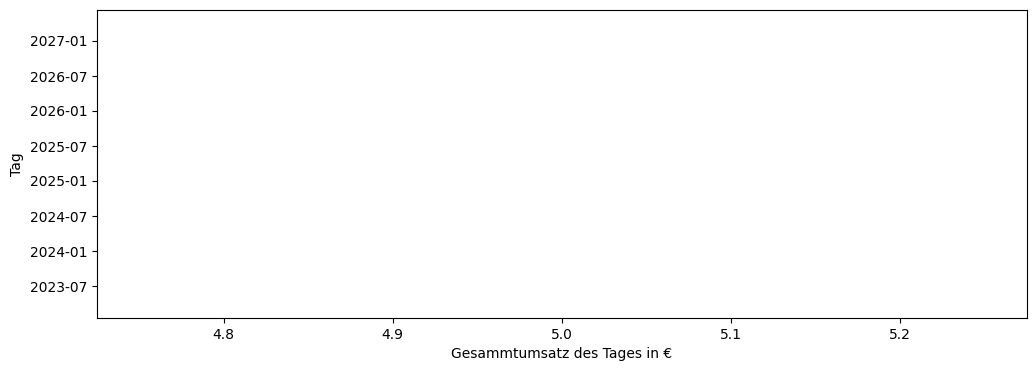

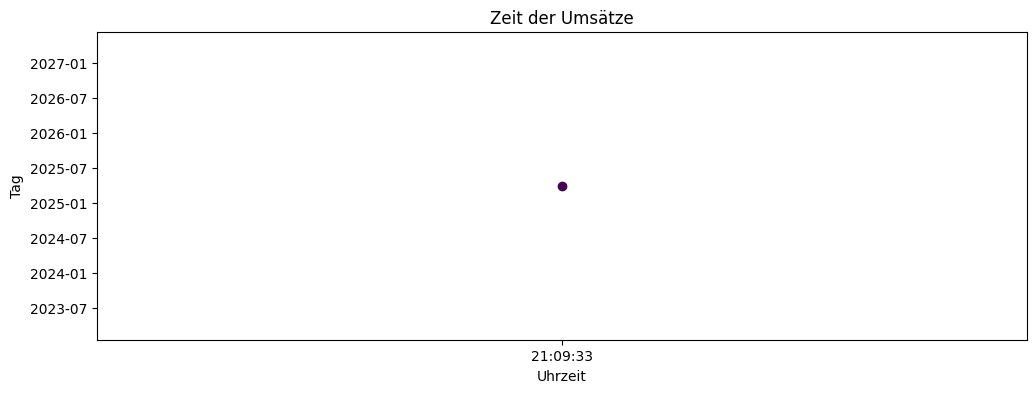

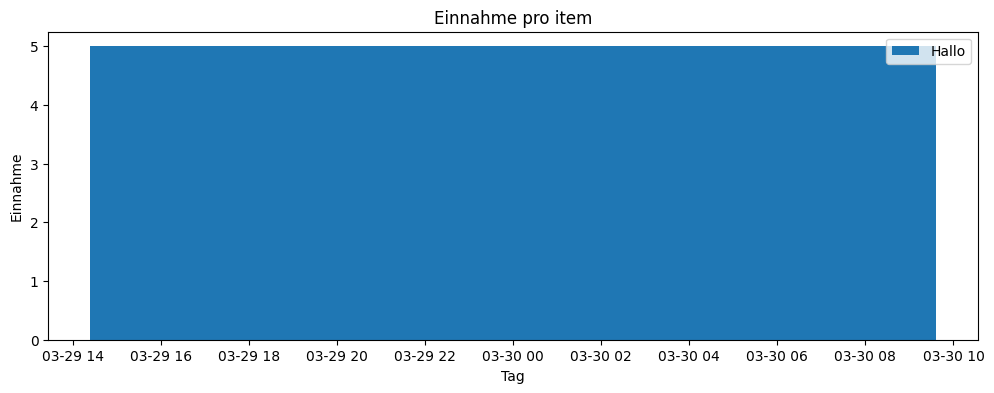

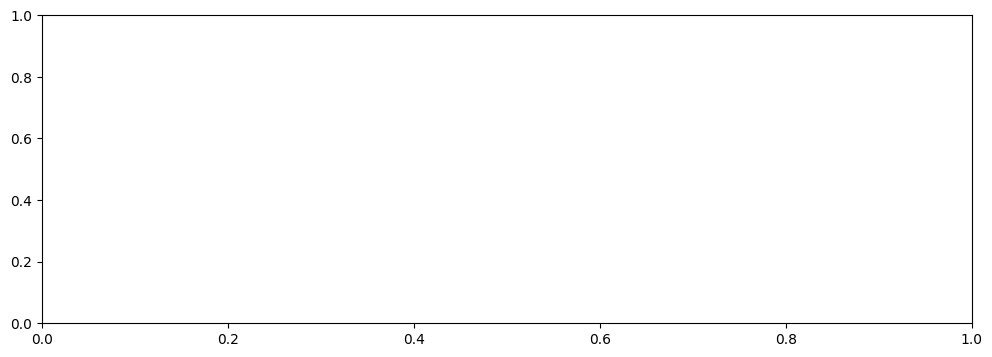

In [54]:
class Window(QWidget):
    def __init__(self, view, creat, stat, imp, chg, hier):
        super().__init__()
        self.setWindowTitle("Sloth")
        layout=QVBoxLayout()
        self.setLayout(layout)
        tabs = QTabWidget()
        
        self.view=view
        self.creat=creat
        self.stat=stat
        self.imp=imp
        self.chg=chg
        self.hier=hier
        tabs.addTab(self.TabUI(self.view), "Overview")
        tabs.addTab(self.TabUI(self.creat), "Erstelle neu")
        tabs.addTab(self.TabUI(self.hier), "Manage Hierachie")
        tabs.addTab(self.TabUI(self.imp), "Importiere")
        tabs.addTab(self.TabUI(self.chg), "Erweiterte Änderung")
        tabs.addTab(self.TabUI(self.stat), "Statisitk")
        #tabs.currentChanged.connect(self.tabChanged)
        layout.addWidget(tabs)

    def TabUI(self,wind):
        generalTab = QWidget()
        generalTab.setLayout(wind.layout)
        return generalTab

if __name__ == "__main__":
    
    app=QApplication([])
    view=App_Overview()
    creat=App_Create()
    stat=App_Stat()
    imp=App_Import()
    chg=App_Filtered()
    hier=App_MangageHierachie()
    
    window=Window(view=view, creat=creat, stat=stat, imp=imp, chg=chg, hier=hier)
    Control_Create(view=creat)
    MangageHierachie(view=hier)
    Control_Import(view=imp)
    #Control_Filtered(view=chg)
    window.show()
    sys.exit(app.exec())

Annoying:

vermutlich nicht geschützt vor "jason").droptable()", doch wer sollte sein eigenes Projekt vermiesen?

Es wäre viel einfacher, wenn du die ID als index benutzen würdest. Jetzt ist das Kind schon in den Brunnen gefallen

Wie schaffe ich es, dass user keine schreibberechtigung in den Verkäufen haben, sondern nur die programme.
Ich habe Verschlüsselung und hashes eingefügt, aber user können immer noch Schlüssel lesen.

Objekt Orientierung würde Dinge einfacher machen
